# Sentiment analysis in Russian using LSTM and Word2Vec

Загрузим датасет твитов на русском с http://study.mokoron.com/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


print('Hello dicks')

Hello dicks


### Загрузим данные из датасета

В файлах хранятся размеченные твиты, нас интресует только текст

In [2]:
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faworite', 'stcount', 'followers', 'friends', 'listcount']
data_positive = pd.read_csv('data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)

labels = [1] * sample_size + [0] * sample_size

### Отфильтруем данные

* заменим ё на е  
* приведем все к нижнему регистру  
* удалим знаки препинания (вообще говоря, нужно не все) 
* ссылки заменим на тег <\url>
* упоминния пользователей заменим на тег <\user> 
    

In [3]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'url', text)
    text = re.sub('@[^\s]+', 'user', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9:)(;]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

processed_data = [preprocess_text(t) for t in raw_data]
#processed_data = raw_data

Найдем самое длинное предложение (твит)

In [4]:
max_sentence_len  = 0
sent = ''

for sentence in processed_data:
    if len(sentence) > max_sentence_len:
        max_sentence_len = len(sentence)
        sent = sentence
        
print(max_sentence_len, sent)

173 rt user lt;span style font size: medium; gt; lt;br gt;хоч я amp;nbsp;й amp;nbsp;просив amp;nbsp;не amp;nbsp;додавати amp;nbsp;цей amp;nbsp;журнал amp;nbsp;( lt; span gt; lt;


In [5]:
w2v_data = [[w for w in processed_data[i].split()] for i in range(len(processed_data))]

w2v_data[0]

['user',
 'хоть',
 'я',
 'и',
 'школота',
 'но',
 'поверь',
 'у',
 'нас',
 'то',
 'же',
 'самое',
 ':d',
 'общество',
 'профилирующий',
 'предмет',
 'типа)']

### Обучим модел word2vec

In [35]:
%%time
import logging
import multiprocessing
from gensim.models import Word2Vec, word2vec

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#w2v_model = Word2Vec(w2v_data, size=max_sentence_len, window=3, min_count=1, iter=10, workers=multiprocessing.cpu_count()) 
#w2v_model.save('w2v/tweets_labeled.w2v')

w2v_model = Word2Vec.load('w2v/tweets_labeled.w2v')

predtrained_weights = w2v_model.wv.vectors
vocab_size, emdedding_size = w2v_model.wv.vectors.shape

2019-03-27 16:04:02,384 : INFO : loading Word2Vec object from w2v/tweets_labeled.w2v
2019-03-27 16:04:03,802 : INFO : loading wv recursively from w2v/tweets_labeled.w2v.wv.* with mmap=None
2019-03-27 16:04:03,802 : INFO : loading vectors from w2v/tweets_labeled.w2v.wv.vectors.npy with mmap=None
2019-03-27 16:04:04,066 : INFO : setting ignored attribute vectors_norm to None
2019-03-27 16:04:04,066 : INFO : loading vocabulary recursively from w2v/tweets_labeled.w2v.vocabulary.* with mmap=None
2019-03-27 16:04:04,066 : INFO : loading trainables recursively from w2v/tweets_labeled.w2v.trainables.* with mmap=None
2019-03-27 16:04:04,066 : INFO : loading syn1neg from w2v/tweets_labeled.w2v.trainables.syn1neg.npy with mmap=None
2019-03-27 16:04:04,324 : INFO : setting ignored attribute cum_table to None
2019-03-27 16:04:04,324 : INFO : loaded w2v/tweets_labeled.w2v


Wall time: 2.4 s


Функция визуализации слов в пространстве *w2v*

In [7]:
def tsne_plot(labels, tokens, classes, clusters):
    tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=33)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    colors = cm.rainbow(np.linspace(0, 1, num=clusters))

    plt.figure(figsize=(16, 9))
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i], c=[colors[classes[i]]], alpha=0.75)
        plt.annotate(labels[i], alpha=0.75, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.grid(True)
    #plt.show()

Выведем для примера по 10 синонимов для каждого из  8 слов

2019-03-27 15:46:37,355 : INFO : precomputing L2-norms of word weight vectors


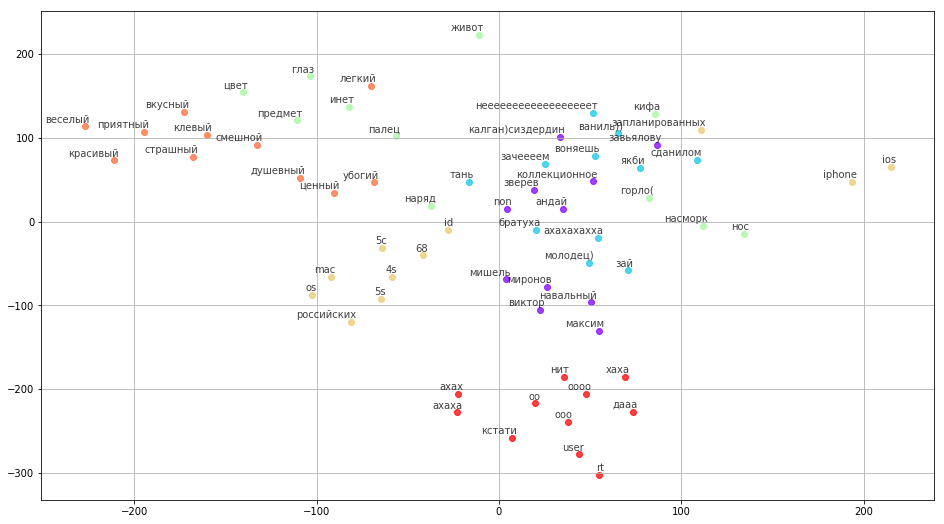

In [8]:
lb = []
tokens = []
classes = []

samples = 8
for i, word in enumerate(['виктор', 'прaвый', 'воняешь', 'F#ошибка', 'глаз', 'iphone', 'вкусный', 'user']):
    if word not in w2v_model.wv.vocab:
        continue
    tokens.append(w2v_model.wv[word])
    lb.append(word)
    classes.append(i)
    for similar_word, similarity in w2v_model.wv.most_similar(word, topn=10):
        tokens.append(w2v_model.wv[similar_word])
        lb.append(similar_word)
        classes.append(i)
        
tsne_plot(lb, tokens, classes, samples)

### Перемешаем данные

In [10]:
from sklearn.utils import shuffle

features_shuf, labels_shuf = shuffle(processed_data, labels, random_state=666)

### Построение модели

In [11]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, LSTM, Dropout
from keras.layers import SpatialDropout1D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Создаем сеть
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[predtrained_weights]))
#model.add(Embedding(NUM, DIM, input_length=SENTENCE_LENGTH, mask_zero=True))
model.add(BatchNormalization())
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation='relu', return_sequences=True))
model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, activation='relu'))
model.add(Dense(1, activation="sigmoid"))

# Копмилируем модель
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])


Using TensorFlow backend.


### Обучение модели

In [30]:
# Генератор пакетов (батчей)

def generator(features, labels, batch_size):
    x = np.zeros((batch_size, max_sentence_len), dtype=np.int)
    y = np.zeros((batch_size), dtype=np.int)
   
    while True:
        for i in range(batch_size):
            index = np.random.choice(len(features))
            for t, word in enumerate(features[index].split()):
                x[i, t] = w2v_model.wv.vocab[word].index
            y[i] = labels[index]
                
        yield x, y
        

In [ ]:
# Гиперпараметры
NUM_EPOCHS = 5
BATCH_SIZE = 128

# Обучаем модель
history = model.fit_generator(generator(features_shuf, labels_shuf, BATCH_SIZE),
                              steps_per_epoch=int(len(features_shuf)/BATCH_SIZE) + 1,
                              epochs=NUM_EPOCHS,
                              verbose=1)

### Выведем статистику обучения

In [ ]:
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

%pylab inline
plt.figure(figsize(10,7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


In [ ]:
# Проверяем качество обучения на тестовых данных
scores = model.evaluate(x_test_seq, y_test, batch_size=BATCH_SIZE)

print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

In [ ]:
scores

### Примеры работы

Обычные высказывания

In [ ]:
s0 = 'Вообще говоря, мне не по душе этот момент. Ужасно тормозит. стоит дохрена!!! Зря выкинул деньги'
s1 = 'Если немного дорабоать, полчится достойная альтернатива iphone'
s2 = 'Кусь. Фиговая фигня, но я балдею'
s3 = 'Крч, fuck u gays!!!'
s4 = 'Ничего не понятно, но в целом неплохо('
s5 = 'Когда я первый раз зашел домой, я обрадовался столь плохому освещению'

statements = list([s0, s1, s2, s3, s4, s5])

filterd_statements = [preprocess_text(t) for t in statements]
statements_seq = get_sequences(tokenizer, filterd_statements)

In [ ]:
pred = model.predict(statements_seq)

In [ ]:
np.set_printoptions(precision=2)
for t in pred:
    print(t)

### Примеры отзывов на приложенеие "Мегафон" из Google Play

In [ ]:
m0 = 'глюкопрога ничего не решает, пишет ошибка.'
m1 = 'Не могу зайти в личный кабинет,30минут ждала пока загрузится,так и не звгрузился!!!!!'
m2 = '''С сегодняшнего дня приложение просто перестало работать. 
Оператор выслал ссылку по ней все работает. Пробовал переустановить приложение, без результатов.'''

m3 = '''верните иконки(виджеты) чтоб можно было вывести на главный экран телефона, 
очень удобно следить за балансом, и остатком трафика и т.д. не нужно постоянно заходить в личный кабинет. 
уважаемые разработчики а можно что бы виджеты работали на старых телефонах? у меня один из телефонов андройд 4.2.2. 
спасибо запонимание.(большая аудитория).у кого дорогие старые телефоны.'''

m4 = '''По работе приложения вопросов нет. Перешел на МегаФон с Билайна. 
И там и там использовал тарифный план с включенными пакетами услуг. 
И вот на мегафоне решили сделать гениально. Пока есть пакет минут, звонки на все номера (в том числе и мегафон)
списываются с пакета включенных минут. А вот когда пакет заканчивается, пожалуйста, звоните на мегафон бесплатно. 
В качестве информации: на Билайне пакет минут расходуется, только, на разговоры с другими операторами. 
Пожалел о переходе в первый же день!!!'''

m5 = 'ну конечно я не собиралась пистаь этот отзыв но все-таки удобная прога ставлю пять звезд'

In [ ]:
statements = list([m0, m1, m2, m3, m4, m5])

filterd_statements = [preprocess_text(t) for t in statements]
statements_seq = get_sequences(tokenizer, filterd_statements)

In [ ]:
pred = model.predict(statements_seq)
for t in pred:
    print(t)